# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
"""
Behavior Cloning Project. Steering from Images
"""

#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image

import keras
import math
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.misc.pilutil import imresize

from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint

import csv
import cv2

import os
import argparse
import json


Using TensorFlow backend.


In [2]:
#
# Read 10 lines for displaying the images 
#
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

imagesC = []
imagesL = []
imagesR = []
measurements = []
i = 0;
for line in lines:
    source_path = line[0]
    filenameC = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filenameC
    imageC = cv2.imread(current_path)
    imagesC.append(imageC)
    source_pathL = line[1]
    filenameL = source_pathL.split('/')[-1]
    current_path = 'data/IMG/' + filenameL
    imageL = cv2.imread(current_path)
    imagesL.append(imageL)
    source_pathR = line[2]
    filenameR = source_pathR.split('/')[-1]
    current_path = 'data/IMG/' + filenameR
    imageR = cv2.imread(current_path)
    imagesR.append(imageR)
    measurement = float(line[3])
    measurements.append(measurement)
    if(i > 10):
        break
    else:
        i += 1

(160, 320, 3) 153600 uint8


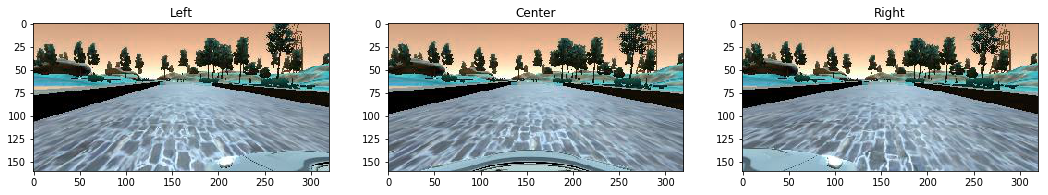

In [3]:
#
# Show the raw images.
#
imageC0 = imagesC[0]
imageL0 = imagesL[0]
imageR0 = imagesR[0]
print(imageC0.shape, imageC0.size, imageC0.dtype)

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(imageR0)

(80, 320, 3)

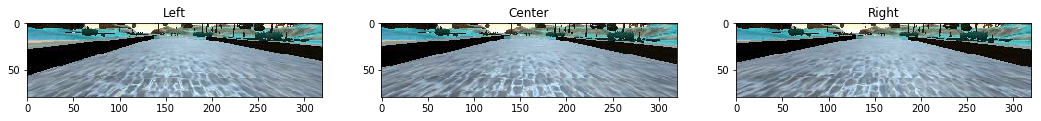

In [4]:
#
# Crop and show the images.
#
crop_start = 50
crop_end = 130
crop_imageL0 = imageL0[crop_start:crop_end, :]
crop_imageC0 = imageC0[crop_start:crop_end, :]
crop_imageR0 = imageR0[crop_start:crop_end, :]
#crop_imageR0 = cv2.resize(crop_imageR0, (320, 160), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(crop_imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(crop_imageR0)
crop_imageL0.shape

In [5]:
#
# Flag low steering angles with a probability of 50%
#
def check_good_steering_angle(yi): 
    probability = random.random()
    if (probability > 0.5 or abs(yi) > 0.01):
       return True
    else:
        return False

In [6]:
#
# Fill the samples array. Skip the first line. Split it into training and validation sets.
#
samples = []
linec = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(linec > 0):
            samples.append(line)
        linec = linec + 1

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Training set size ', len(train_samples))
print('Validation set size ', len(validation_samples))

# Reduce the pictures with low steering angles.
good_train_samples = []
 
for tsam in train_samples:
    name = 'data/IMG/'+tsam[0].split('/')[-1]
    center_angle = float(tsam[3])
    if(check_good_steering_angle(center_angle)):
#        print('Steering ', center_angle, tsam[0])
        good_train_samples.append(tsam)

print('Good training set size ', len(good_train_samples))
train_samples = good_train_samples

Training set size  6428
Validation set size  1608
Good training set size  4686


Shape  (80, 320, 3)  Steer  0.18816059306235686


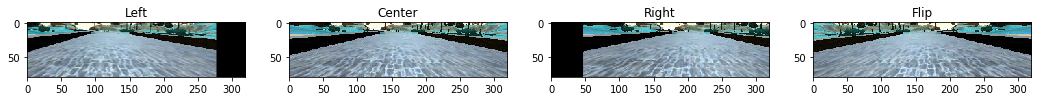

In [7]:
trans_range = 100

def trans_image(image,steer):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 0
    rows, cols, ch = image.shape
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr,steer_ang

def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage

sangle = measurements[0]
plt.figure(figsize=(18,6))
plt.subplot(141)
plt.title('Left')
lcimage, steer = trans_image(crop_imageL0, sangle)
plt.imshow(lcimage)
plt.subplot(142)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(143)
plt.title('Right')
rctimage, steer = trans_image(crop_imageR0, sangle)
plt.imshow(rctimage)
print('Shape ', rctimage.shape, ' Steer ', steer)
plt.subplot(144)
plt.title('Flip')
plt.imshow(flip_image(crop_imageC0))

Epoch 1/3
4686/4686 [==============================] - 130s - loss: 0.1350 - val_loss: 0.0316
Epoch 2/3
4686/4686 [==============================] - 87s - loss: 0.0273 - val_loss: 0.0235
Epoch 3/3
4686/4686 [==============================] - 74s - loss: 0.0224 - val_loss: 0.0183
dict_keys(['val_loss', 'loss'])


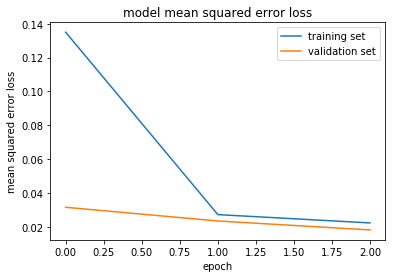

In [8]:

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                cname = 'data/IMG/'+batch_sample[0].split('/')[-1]
                lname = 'data/IMG/'+batch_sample[1].split('/')[-1]
                rname = 'data/IMG/'+batch_sample[2].split('/')[-1]
                sangle = float(batch_sample[3])
                use_angle = sangle
                if(sangle < 0.01):
                    chance = random.random()
                    if(chance > 0.75):
#                    if(chance > 1.0):
                        rimage = cv2.imread(rname)
                        use_image, use_angle = trans_image(rimage, sangle)
                        #use_angle = use_angle - 0.25
                    else:
                        if(chance > 0.49):
#                        if(chance > 1.0):
                            rimage = cv2.imread(rname)
                            use_image, use_angle = trans_image(rimage, sangle)
                            #use_angle = use_angle - 0.25
                        else:
                            cimage = cv2.imread(cname)
                            use_image = cimage
                elif(sangle > 0.01):
                    chance = random.random()
                    if(chance > 0.75):
#                    if(chance > 1.0):
                        limage = cv2.imread(lname)
                        use_image, use_angle = trans_image(limage, sangle)
                        #use_angle = use_angle + 0.25
                    else:
                        if(chance > 0.49):
#                        if(chance > 1.0):
                            limage = cv2.imread(lname)
                            use_image, use_angle = trans_image(limage, sangle)
                            #use_angle = use_angle + 0.25
                        else:
                            cimage = cv2.imread(cname)
                            use_image = cimage
               
                if np.random.choice([True, False]):
                    use_image = flip_image(use_image)
                    use_angle = -use_angle
            
                images.append(use_image)
                angles.append(use_angle)
 
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
model.add(Cropping2D(cropping=((50,30), (0,0)), input_shape=(160,320,3)))

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch)))

model.add(Convolution2D(24,5,5, input_shape=(row,col,ch), subsample = (2,2),
                        border_mode='same',
                        name='conv1', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(36,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(48,5,5, subsample = (2,2),
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
   
model.add(Flatten())
model.add(Dense(100,name='hidden1', init='he_normal'))

model.add(ELU())
    
model.add(Dense(50,name='hidden2', init='he_normal'))
    
model.add(ELU())
    
model.add(Dense(10,name='hidden3',init='he_normal'))
    
model.add(ELU())
    
model.add(Dense(1, name='output', init='he_normal'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam)

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
            validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')

In [9]:
model.save('model.h5')

#Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas